In [1]:
import tensorflow as tf

In [2]:
!pip install imageio

In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-bln3qm6_
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-bln3qm6_
  Resolved https://github.com/tensorflow/docs to commit 0e030ebf893fff8819a108d5f4449ae1829e2a8d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.10.13.34193-py3-none-any.whl size=187038 sha256=823a97c5d87071ab22ed434f5fdd881c3b3b15df2a2fd0a8bcdbe7943d70c3b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ay25xol/wheels/3e/88/34/48d2789bc9d37b33ddce06bccc454fae0285e5396d0a5be9d9
Successfully built tensorflow-docs


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# Chargement et traiment des données

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Prétraitement des images

In [6]:
# Réorganisation des images d'entraînement pour les préparer à la phase d'entraînement
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Explication : Les images d'entraînement sont généralement remodelées pour correspondre au format d'entrée attendu par le modèle d'apprentissage. Dans ce cas, les images sont remodelées pour avoir une taille de (28, 28, 1), ce qui signifie qu'elles sont en niveaux de gris (1 canal) et ont une taille de 28x28 pixels.

# Normalisation des images pour les ramener dans la plage [-1, 1]
train_images = (train_images - 127.5) / 127.5
# Explication : La normalisation est effectuée pour que les valeurs de pixel dans les images soient mises à l'échelle dans une plage standard. La plage [-1, 1] est couramment utilisée pour les images, car elle est centrée autour de zéro, ce qui est important pour certains types de modèles, comme les réseaux de neurones convolutifs (CNN). En normalisant les valeurs de pixel, on facilite également l'entraînement du modèle, car cela peut améliorer la stabilité numérique et la convergence de l'entraînement. Cette plage permet également au modèle de mieux gérer les valeurs négatives et positives dans les données d'entrée.

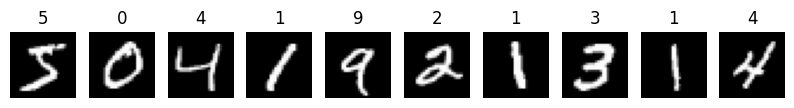

In [7]:
# Afficher 10 images
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(train_labels[i])
    plt.axis('off')
plt.show()

In [8]:
# Définition du BUFFER_SIZE pour le mélange des données
BUFFER_SIZE = 60000

# Définition du BATCH_SIZE pour l'entraînement par mini-lots
BATCH_SIZE = 256

In [9]:
# Création d'un ensemble de données TensorFlow à partir des images d'entraînement

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Création du générateur

In [10]:
def make_generator_model():
    """
    Crée et retourne un modèle de générateur.

    Ce modèle génère de nouvelles images à partir de données aléatoires.

    Returns:
        model: Modèle de générateur.
    """
    model = tf.keras.Sequential()

    # Couche 1 : Une couche Dense (entièrement connectée) initiale
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))  # Activation LeakyReLU pour introduire une non-linéarité

    # Remodelage pour une forme de tableau (7, 7, 256)
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Vérification de la forme de sortie

    # Couche 2 : Une couche de déconvolution (transposée) pour agrandir l'image
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Couche 3 : Une autre couche de déconvolution pour agrandir davantage l'image
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Couche 4 : Couche finale de déconvolution avec activation 'tanh' pour la sortie
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


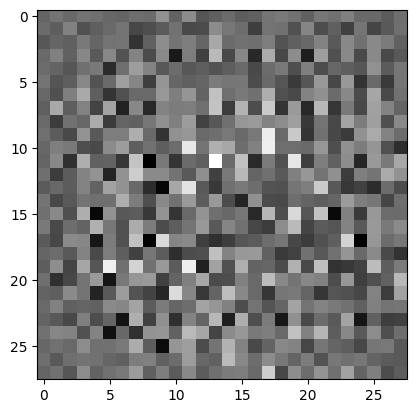

In [11]:
# Création du générateur
generator = make_generator_model()
# Explication : On crée une instance du modèle de générateur en appelant la fonction `make_generator_model()` que nous avons définie précédemment.

# Génération de données aléatoires (bruit)
noise = tf.random.normal([1, 100])
# Explication : On génère un vecteur de bruit aléatoire de taille (1, 100) en utilisant une distribution normale (gaussienne) de TensorFlow. Ce bruit sera l'entrée du générateur.

# Génération d'une image à partir du bruit en utilisant le générateur
generated_image = generator(noise, training=False)
# Explication : On passe le vecteur de bruit au modèle de générateur pour générer une image. La variable `training=False` est définie pour indiquer que le modèle est en mode d'inférence (évaluation), et non en mode d'entraînement.

# Affichage de l'image générée
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
# Explication : On affiche l'image générée en utilisant la bibliothèque Matplotlib. L'indice [0, :, :, 0] est utilisé pour extraire la première et unique image de la sortie, puis on l'affiche en niveaux de gris.

# Discriminateur

In [12]:
def make_discriminator_model():
    """
    Crée et retourne un modèle de discriminateur.

    Ce modèle est utilisé pour évaluer si une image donnée est réelle ou générée.

    Returns:
        model: Modèle de discriminateur.
    """
    model = tf.keras.Sequential()

    # Couche 1 : Convolution 2D avec 64 filtres, taille de noyau (5, 5), et stride de (2, 2)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                          input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(alpha=0.2))  # Activation LeakyReLU pour introduire une non-linéarité
    model.add(layers.Dropout(0.3))  # Dropout pour la régularisation

    # Couche 2 : Autre convolution 2D avec 128 filtres et taille de noyau (5, 5)
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Couche 3 : Aplatir les données en vue d'une couche Dense
    model.add(layers.Flatten())

    # Couche 4 : Couche Dense avec une seule sortie (classification binaire)
    model.add(layers.Dense(1))

    return model

In [13]:
# Création du modèle de discriminateur en utilisant la fonction make_discriminator_model()
discriminator = make_discriminator_model()

# Évaluation de l'image générée par le modèle de discriminateur
decision = discriminator(generated_image)

# Affichage de la décision du générateur
print(decision)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[-0.00059567]], shape=(1, 1), dtype=float32)


In [14]:
# Cette méthode renvoie une fonction auxiliaire pour calculer la perte d'entropie croisée
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    """
    Calcule la perte du discriminateur pour un lot d'images réelles et générées.

    Args:
        real_output: Sortie du discriminateur pour les images réelles.
        fake_output: Sortie du discriminateur pour les images générées.

    Returns:
        total_loss: La perte totale du discriminateur.
    """
    # Calcul de la perte pour les images réelles (real_loss)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Calcul de la perte pour les images générées (fake_loss)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Perte totale du discriminateur (somme de la perte pour les images réelles et générées)
    total_loss = real_loss + fake_loss

    return total_loss

In [16]:
def generator_loss(fake_output):
    """
    Calcule la perte du générateur pour un lot d'images générées.

    Args:
        fake_output: Sortie du discriminateur pour les images générées.

    Returns:
        total_loss: La perte du générateur.
    """
    # Calcul de la perte du générateur en comparant la sortie du discriminateur pour les images générées aux étiquettes attendues (1 pour "vraies" images)
    generator_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    return generator_loss

In [17]:
# Définition des optimiseurs pour le générateur et le discriminateur
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
# Définition des paramètres pour la sauvegarde des points de contrôle (checkpoints)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Création d'un objet de point de contrôle (checkpoint) pour les composants du modèle
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,  # Optimiseur du générateur
    discriminator_optimizer=discriminator_optimizer,  # Optimiseur du discriminateur
    generator=generator,  # Modèle du générateur
    discriminator=discriminator  # Modèle du discriminateur
)

In [28]:
# Nombre d'époques d'entraînement
EPOCHS = 50

# Dimension du vecteur de bruit (utilisé pour générer des images)
noise_dim = 100

# Nombre d'exemples à générer à chaque itération
num_examples_to_generate = 16

# Une graine (seed) de valeurs aléatoires qui sera réutilisée au fil du temps
# (pour visualiser plus facilement la progression dans l'animation GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [29]:
@tf.function
def train_step(images):
    """
    Effectue une étape d'entraînement pour le modèle GAN.

    Args:
        images: Un lot d'images réelles provenant de l'ensemble de données.

    Returns:
        gen_loss: Perte du générateur pour cette étape.
        disc_loss: Perte du discriminateur pour cette étape.
    """
    # Génération de données aléatoires de bruit pour le générateur
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Utilisation de GradientTape pour suivre les gradients
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Génération d'images à partir du générateur
        generated_images = generator(noise, training=True)

        # Évaluation du discriminateur sur les images réelles et générées
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calcul des pertes pour le générateur et le discriminateur
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calcul des gradients des pertes par rapport aux variables du générateur et du discriminateur
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Application des gradients pour mettre à jour les poids des modèles
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [30]:
def train(dataset, epochs):
    """
    Entraîne le modèle GAN sur un ensemble de données pour un nombre d'époques donné.

    Args:
        dataset: Ensemble de données d'entraînement.
        epochs: Nombre d'époques d'entraînement.

    Returns:
        None
    """
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            # Exécute une étape d'entraînement pour le GAN
            train_step(image_batch)

        # Produit des images pour l'animation GIF pendant l'entraînement
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Sauvegarde le modèle tous les 15 époques
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Affiche le temps écoulé pour cette époque
        print("Temps pour l'époque {} : {} sec".format(epoch + 1, time.time() - start))

    # Génère des images après la dernière époque
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


In [31]:
def generate_and_save_images(model, epoch, test_input):
    """
    Génère et sauvegarde des images à partir du modèle générateur.

    Args:
        model: Le modèle générateur utilisé pour générer des images.
        epoch: Le numéro de l'époque (utilisé dans le nom du fichier de sauvegarde).
        test_input: Un vecteur de bruit pour générer des images.

    Returns:
        None
    """
    # Activation du mode d'inférence (inference) pour éviter l'entraînement des couches comme la batch normalization
    predictions = model(test_input, training=False)

    # Création d'une nouvelle figure pour afficher les images générées
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        # Affichage de chaque image générée dans une sous-figure
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # Sauvegarde de la figure en tant qu'image
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

    # Affichage de la figure
    plt.show()

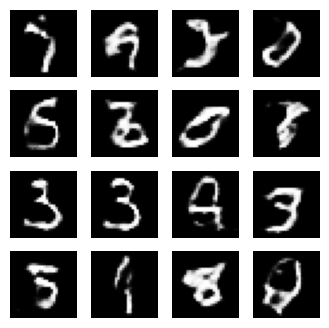

In [32]:
train(train_dataset, EPOCHS)# Entrainement du modèle

In [33]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [34]:
# Afficher les images
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [35]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmp/ipython-input-1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipython-input-1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



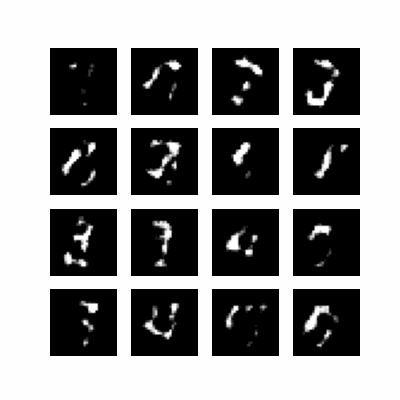

In [36]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)